In [22]:
import requests
import pandas as pd
import json
import io
import itertools
import datetime
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
full_game_logs_df = pd.read_csv('data-full/2021_22_NBA_REG_GAME_LOGS_COMBINED.csv')

In [37]:
full_game_logs_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,PW_POS,PW_PF,PW_PFD,PW_FGM_PAINT,PW_FGM_2PT_MR,PW_PIE_AVG,PW_USG_PCT_AVG,CAREER_INJURIES,DAYS_LAST_INJURY,OUT_NEXT_GAME
0,2021-22,203497,Rudy Gobert,1610612762,UTA,Utah Jazz,22101230,2022-04-10T00:00:00,UTA @ POR,W,...,198,11,21,19.0,0.0,0.169333,0.200000,24,16,0
1,2021-22,201144,Mike Conley,1610612762,UTA,Utah Jazz,22101230,2022-04-10T00:00:00,UTA @ POR,W,...,146,6,6,4.0,0.0,0.079500,0.206000,64,5,0
2,2021-22,203903,Jordan Clarkson,1610612762,UTA,Utah Jazz,22101230,2022-04-10T00:00:00,UTA @ POR,W,...,167,1,5,7.0,0.0,0.139000,0.223667,7,70,0
3,2021-22,1628384,O.G. Anunoby,1610612761,TOR,Toronto Raptors,22101226,2022-04-10T00:00:00,TOR @ NYK,L,...,0,0,0,0.0,0.0,0.000000,0.000000,22,9,0
4,2021-22,1627751,Jakob Poeltl,1610612759,SAS,San Antonio Spurs,22101219,2022-04-10T00:00:00,SAS @ DAL,L,...,116,7,8,11.0,1.0,0.157500,0.236000,12,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6694,2021-22,1629673,Jordan Poole,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,2,598,0
6695,2021-22,203110,Draymond Green,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,45,158,0
6696,2021-22,203952,Andrew Wiggins,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,13,158,0
6697,2021-22,201988,Patty Mills,1610612751,BKN,Brooklyn Nets,22100001,2021-10-19T00:00:00,BKN @ MIL,L,...,0,0,0,0.0,0.0,0.000000,0.000000,10,1739,0


In [38]:
full_game_logs_df.columns

Index(['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'PFD', 'PTS', 'USG_PCT', 'PIE',
       'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY', 'OUT_NEXT_GAME'],
      dtype='object')

In [39]:
# get subset of numerical game stats
# remove FG3M, FTM, FGM as they were used to calculate FGM_PAINT, FGM_2PT_MR, PW_FGM_PAINT, PW_FGM_2PT_MR
# remove PTS as FGA, FTA shot attempts better encapsulate court activity
game_logs_subset = ['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'PFD', 'USG_PCT', 'PIE',
       'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY', 'OUT_NEXT_GAME']

In [40]:
game_logs_data = full_game_logs_df[game_logs_subset]

In [41]:
game_logs_data.columns

Index(['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK',
       'PF', 'PFD', 'USG_PCT', 'PIE', 'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR',
       'AGE', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'FGM_PAINT',
       'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES', 'PW_FG3A', 'PW_FG2A', 'PW_OREB',
       'PW_DREB', 'PW_ASTS', 'PW_TOV', 'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF',
       'PW_PFD', 'PW_FGM_PAINT', 'PW_FGM_2PT_MR', 'PW_PIE_AVG',
       'PW_USG_PCT_AVG', 'CAREER_INJURIES', 'DAYS_LAST_INJURY',
       'OUT_NEXT_GAME'],
      dtype='object')

In [42]:
game_logs_data.corr()

,MIN,FGA,FG3A,FTA,OREB,DREB,AST,TOV,STL,BLK,...,PW_POS,PW_PF,PW_PFD,PW_FGM_PAINT,PW_FGM_2PT_MR,PW_PIE_AVG,PW_USG_PCT_AVG,CAREER_INJURIES,DAYS_LAST_INJURY,OUT_NEXT_GAME
MIN,1.000000,0.610269,0.310733,0.358177,0.100946,0.297301,0.376485,0.315127,0.181537,0.087985,...,0.203781,0.084240,0.271175,0.216866,0.239746,0.201523,0.258229,0.092887,-0.015338,-0.089675
FGA,0.610269,1.000000,0.505073,0.422355,0.072772,0.215734,0.345942,0.330832,0.130957,0.004164,...,0.150525,0.046865,0.369135,0.296970,0.364597,0.264780,0.492593,0.061965,-0.046881,-0.019820
FG3A,0.310733,0.505073,1.000000,0.010978,-0.288831,-0.152811,0.163464,0.107647,0.066695,-0.163635,...,0.051319,-0.084382,-0.046528,-0.187515,0.050908,-0.072451,0.174192,-0.027552,0.032124,-0.024610
FTA,0.358177,0.422355,0.010978,1.000000,0.142941,0.279077,0.220017,0.279826,0.076876,0.109883,...,0.083285,0.072690,0.435945,0.324182,0.217503,0.304545,0.352777,0.110467,-0.077391,-0.009327
OREB,0.100946,0.072772,-0.288831,0.142941,1.000000,0.322539,-0.083436,0.030518,-0.001930,0.260457,...,0.005531,0.135115,0.123283,0.261434,-0.100004,0.178095,-0.021697,-0.000515,-0.030197,-0.018617
DREB,0.297301,0.215734,-0.152811,0.279077,0.322539,1.000000,0.098126,0.204516,0.037659,0.270461,...,0.051948,0.142135,0.269493,0.321427,0.055811,0.316251,0.156269,0.081285,-0.022651,-0.034855
AST,0.376485,0.345942,0.163464,0.220017,-0.083436,0.098126,1.000000,0.336399,0.176647,-0.071684,...,0.102734,-0.006049,0.240481,0.129615,0.258019,0.209782,0.275259,0.164415,-0.060318,0.000642
TOV,0.315127,0.330832,0.107647,0.279826,0.030518,0.204516,0.336399,1.000000,0.089213,0.012023,...,0.081725,0.056230,0.282857,0.205551,0.188308,0.231996,0.315004,0.088995,-0.025834,-0.002490
STL,0.181537,0.130957,0.066695,0.076876,-0.001930,0.037659,0.176647,0.089213,1.000000,0.016608,...,0.015743,0.027728,0.040964,0.009703,0.038051,0.056564,0.042046,0.073806,-0.016730,-0.017448
BLK,0.087985,0.004164,-0.163635,0.109883,0.260457,0.270461,-0.071684,0.012023,0.016608,1.000000,...,-0.041186,0.075298,0.069589,0.135748,-0.063866,0.129898,-0.008605,0.088600,-0.030995,-0.011751


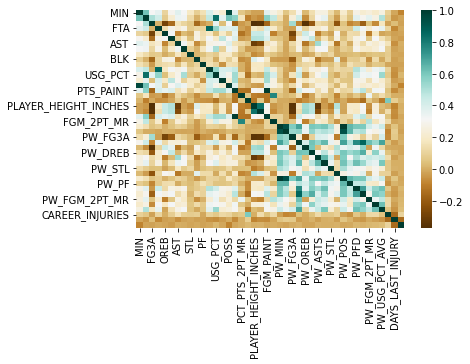

In [43]:
sns.heatmap(game_logs_data.corr(), cmap='BrBG');

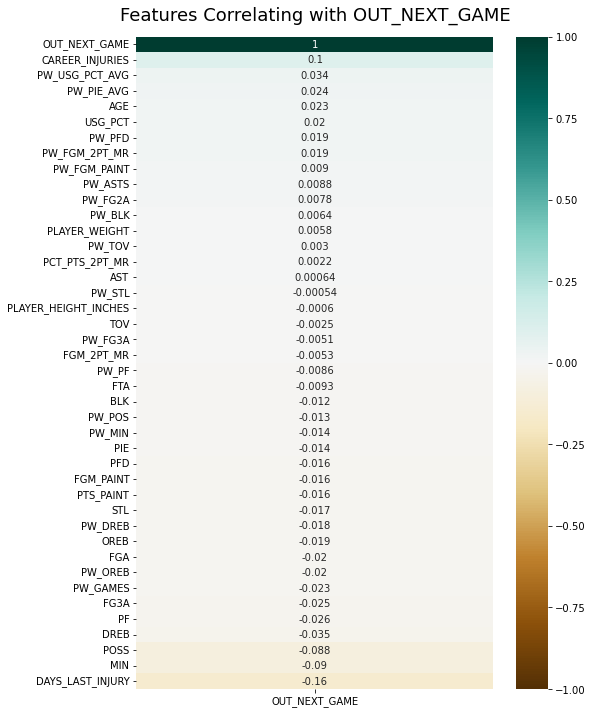

In [44]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(game_logs_data.corr()[['OUT_NEXT_GAME']].sort_values(by='OUT_NEXT_GAME', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with OUT_NEXT_GAME', fontdict={'fontsize':18}, pad=16);

In [45]:
# do we need to standardize anything?
# do not standarize: USG_PCT, PIE, PW_PIE_AVG, PW_USG_PCT_AVG

In [46]:
game_logs_data.columns

Index(['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK',
       'PF', 'PFD', 'USG_PCT', 'PIE', 'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR',
       'AGE', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'FGM_PAINT',
       'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES', 'PW_FG3A', 'PW_FG2A', 'PW_OREB',
       'PW_DREB', 'PW_ASTS', 'PW_TOV', 'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF',
       'PW_PFD', 'PW_FGM_PAINT', 'PW_FGM_2PT_MR', 'PW_PIE_AVG',
       'PW_USG_PCT_AVG', 'CAREER_INJURIES', 'DAYS_LAST_INJURY',
       'OUT_NEXT_GAME'],
      dtype='object')